In [1]:
!pip install pandas_ta
!pip install neat-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=c41efd9e8a7e21f7cb05781aa748e9e90d00ccf3d57735f50da2a818a430cf8a
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 3.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
use_collab = True
if use_collab:
  csv_dir = '/content/drive/MyDrive/eurusd_hour.csv'
  config_dir = '/content/drive/MyDrive/config-feedforward'
else:
  csv_dir = '/tmp/eurusd_hour.csv'
  config_dir = '/tmp/config-feedforward'

In [4]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import random
import neat
import string

In [5]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [6]:
df = pd.read_csv(csv_dir)
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']


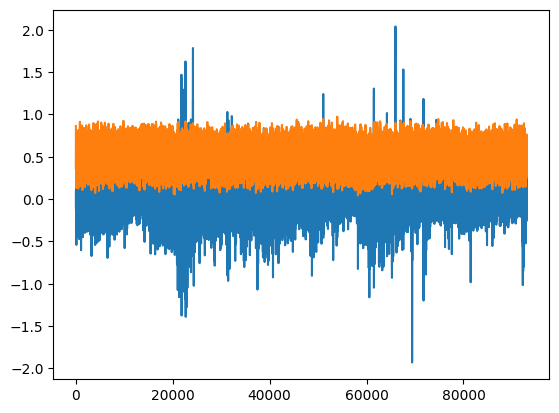

In [127]:
close_np = close.to_numpy()


# Calculate the rolling velocity
RSI = ta.rsi(close,10,scalar=1)
ROC = ta.roc(close,8,scalar=50)
CHANGE = get_relative_change(close,"Change")

INDICATORS = pd.concat([ROC,RSI,CHANGE],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()
INDICATORS.pop('index')

change = INDICATORS.pop('Change')
INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()
change_dev = change.std()
change = change/change_dev


plt.plot(INDICATORS)

In [8]:
def softmax(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x

In [9]:
def clamp(num, min_value, max_value):
    return max(min(num, max_value), min_value)

In [10]:
outputs = [.6,.7,.8,.10]
action = outputs[:3]
maxed = np.argmax(action)
print(maxed)

2


In [11]:
def run_env_loop(net,rand,debug):
    trade_info = np.zeros(4)
    returns = np.array([])

    trade_timer = 0
    trade_value = 0
    trade_direction = 0
    trade_max = 0
    cash_out_val = 0


    for count in range(rand, rand+1000):
        state = np.concatenate((INDICATORS[count], trade_info))
        outputs = net.activate(state)
        action = np.argmax(outputs)
        buy = True if action == 3 else False
        sell = True if action == 2 else False
        cash_out = True if action == 0 else False
        cur_move = change[count]

        if buy or sell:
          cash_out_value = trade_value
          trade_direction = 1 if buy else -1
          trade_value = ((cur_move*trade_direction)-.1)
          trade_max = trade_value
          trade_timer = 0
        elif cash_out:
          cash_out_value = trade_value
          trade_direction = 0
          trade_value = 0
          trade_max = 0
          trade_timer = 0
        else:
          cash_out_value = 0
          trade_value += cur_move*trade_direction if trade_direction != 0 else 0
          trade_max = max(trade_max,trade_value)
          trade_timer += .1


        trade_info = np.array((trade_direction,trade_value,trade_timer,trade_max))

        if cash_out_value != 0:
            returns = np.append(returns,cash_out_value)
        if debug:
          print(trade_info)
          print(cash_out_value)

    return np.sum(returns) if len(returns)>1 else 0

In [201]:
def run_env_loop(net,rand,debug):
    profit = 0
    bought = False
    sold = False
    trade_counter = 0
    for count in range(rand, rand+1000):
        outputs = net.activate(INDICATORS[count])
        action = np.argmax(outputs)

        if action == 0:
          profit += change[count+1]
          trade_counter += 1
          bought = True
        elif action == 1:
          sold = True
          profit += change[count+1]*-1
        else:
          profit += 0

        if debug:
          print([action,profit])


    trade_ratio = trade_counter/1000
    trade_ratio = abs(trade_ratio-.5)*1.5
    penelty = trade_ratio*abs(profit)

    if bought and sold:
      fitness = profit + -penelty
    else:
      fitness = -100

    return fitness

In [202]:
def eval_genomes(genomes, config):
  rand = random.randint(0, 70000)
  for genome_id, genome in genomes:
    genome.fitness = 0.0
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    genome.fitness = run_env_loop(net,rand,False)


In [203]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_dir)

p = neat.Population(config)
p.add_reporter(neat.StdOutReporter(False))
#p.add_reporter(neat.Checkpointer(100, 100,filename_prefix="/content/drive/MyDrive/neat/Neetcheckpoint/"))

In [ ]:
winner = p.run(eval_genomes,50)


 ****** Running generation 0 ****** 

Population's average fitness: -68.74861 stdev: 46.30525
Best fitness: 25.10019 - size: (2, 4) - species 1 - id 107
Average adjusted fitness: 0.250
Mean genetic distance 1.141, standard deviation 0.329
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 2.057 sec

 ****** Running generation 1 ****** 

Population's average fitness: -54.08785 stdev: 50.27914
Best fitness: 71.19454 - size: (2, 4) - species 1 - id 107
Average adjusted fitness: 0.268
Mean genetic distance 1.275, standard deviation 0.354
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 2.195 sec (2.126 average)

 ****** Running generation 2 ****** 

Population's average fitness: -36.64394 stdev: 54.50069
Best fitness: 74.43003 - size: (2, 4) - species 1 - id 158
Average adjusted fitness: 0.363
Mean genetic distance 1.432, standard deviation 0.377
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 1.974 sec (2.

In [199]:
net = neat.nn.FeedForwardNetwork.create(winner, config)

In [200]:
run_env_loop(net,70000,True)

[0, 0.7988013867545268]
[0, 1.7002730762560678]
[0, 1.7888450663531414]
[0, 1.9290689068926865]
[0, 4.600245369299845]
[1, 3.666162240234527]
[1, 2.431930433552364]
[1, 3.187495014305622]
[0, 2.284386856636827]
[0, 2.8724218048726193]
[0, 3.8199487819924167]
[0, 3.8419588640867186]
[0, 3.900650841208082]
[0, 4.186753754996308]
[0, 3.3654113994000237]
[0, 3.042417718050616]
[0, 3.63725398741788]
[0, 3.409765596120066]
[0, 3.3290215120832043]
[0, 3.886944657996607]
[0, 3.9382973817217897]
[0, 3.3367745682498473]
[0, 2.8522666994711194]
[0, 3.175462879254913]
[0, 2.4926127773333646]
[0, 3.6683876130805766]
[0, 2.831847340517747]
[0, 2.251547698403416]
[0, 2.8763628304349314]
[0, 3.0453017488360987]
[0, 3.2288931899989013]
[0, 3.6180199369565105]
[0, 3.3171401170391315]
[0, 3.0969033535573223]
[0, 3.236424103730106]
[0, 3.0675592912953986]
[0, 2.8766293213816048]
[0, 2.839903469555179]
[0, 3.0235409520463397]
[0, 3.0455725168132686]
[0, 3.427442714431826]
[0, 2.8622442434842355]
[0, 3.3029

6.225016212749802

In [194]:


def get_weights(connections, node_name,letter):
    node_weight = ""

    for key, value in connections.items():
        if value.enabled:
            if node_name == letter[value.key[1]]:
                if value.key[0] < 0:
                    from_node_name = "P" + str(value.key[0] * -1)
                    weight = value.weight
                else:
                    from_node_name = letter[value.key[0]]
                    weight = value.weight
                node_weight = node_weight + from_node_name + " * " + str(weight) + " + "


    return(node_weight)





In [195]:
nodes = winner.nodes
conec = winner.connections
node_list = []
letter_dict = dict()
count = 0



for index, node in nodes.items():
    letter_dict[index] = string.ascii_uppercase[count]
    count += 1

for index, node in nodes.items():
    node_name = letter_dict[index]
    activation = node.activation
    bias = str(node.bias) + ")"
    front = node_name + " = " + activation + "("
    weights = get_weights(conec,node_name,letter_dict)
    node_list.append((front+weights+bias))

node_list.reverse()






In [196]:
print(winner)

Key: 7160
Fitness: 34.516685106227214
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.340471108767379, response=1.0, activation=relu, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=0.0029554653431979605, response=1.0, activation=relu, aggregation=sum)
	4 DefaultNodeGene(key=4, bias=-0.6120317754240647, response=1.0, activation=relu, aggregation=sum)
	341 DefaultNodeGene(key=341, bias=1.8985891419592973, response=1.0, activation=relu, aggregation=sum)
	685 DefaultNodeGene(key=685, bias=0.45146763192549877, response=1.0, activation=relu, aggregation=sum)
	913 DefaultNodeGene(key=913, bias=0.27241050590307075, response=1.0, activation=relu, aggregation=sum)
	1109 DefaultNodeGene(key=1109, bias=-0.637189222424538, response=1.0, activation=relu, aggregation=sum)
	1218 DefaultNodeGene(key=1218, bias=-1.0766560031890198, response=1.0, activation=relu, aggregation=sum)
	1288 DefaultNodeGene(key=1288, bias=-0.9407861839311158, response=1.0, activation=relu, aggregation=sum)
	1397 DefaultNodeGene(key=

In [197]:
for item in node_list:
       print(item)

K = relu(J * -1.4328599830857691 + -0.2843405586267677)
J = relu(G * 0.337335545200379 + 0.0141862290460179)
I = relu(E * -0.9235664372881058 + F * -0.14052630526930962 + -0.9407861839311158)
H = relu(P1 * 2.4536405436435893 + -1.0766560031890198)
G = relu(-0.637189222424538)
F = relu(0.27241050590307075)
E = relu(0.45146763192549877)
D = relu(E * 0.11381736540013859 + K * 0.9499627625180505 + I * 1.691448707246924 + 1.8985891419592973)
C = relu(F * 0.23696496793784783 + -0.6120317754240647)
B = relu(P1 * -0.9095949205680868 + 0.0029554653431979605)
A = relu(D * -0.5669043624786626 + F * -0.8014093493188379 + -0.340471108767379)
